In [1]:
import multirex as mrex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import pandas as pd
import os
import re
import gc
import warnings
import joblib

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def remove_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.model_selection import train_test_split

waves=np.loadtxt("waves.txt")
n_points = len(waves)
indices = np.linspace(0, len(waves) - 1, n_points, endpoint=True)
indices = np.round(indices).astype(int)  # Redondear los índices y convertir a entero

# Seleccionar los elementos de la lista usando los índices
puntos_seleccionados = waves[indices]
waves=puntos_seleccionados
wn_grid=np.sort((10000/waves))

Loading MultiREx version 0.2.3


## load data

In [2]:
import os
import re
import numpy as np
import pandas as pd

def apply_contaminations_from_files(contamination_files, df, n_points):
    """
    Applies multiple contaminations to the data from a list of contamination files
    and returns a DataFrame with all combinations, including the non-contaminated case.

    Parameters:
        contamination_files (list of str): Paths to .txt files containing contaminations.
        df (pandas.DataFrame): Original DataFrame to apply contaminations.
        n_points (int): Number of columns to which the contamination will be applied.

    Returns:
        pandas.DataFrame: DataFrame with all combinations of contaminations, including the
        non-contaminated case, with additional columns 'f_spot' and 'f_fac'.
    """
    df_list = []

    # Non-contaminated case: create a copy and add f_spot and f_fac as 0.0
    df_no_contam = df.copy()
    df_no_contam["f_spot"] = 0.0
    df_no_contam["f_fac"] = 0.0
    # Reorder columns to place 'f_spot' and 'f_fac' at the beginning
    cols = ["f_spot", "f_fac"] + [col for col in df_no_contam.columns if col not in ["f_spot", "f_fac"]]
    df_no_contam = df_no_contam[cols]
    df_list.append(df_no_contam)

    # Regular expression to extract f_spot and f_fac from the file name.
    # Expected pattern: fspot<value>_ffac<value>.txt
    pattern = r"fspot(?P<f_spot>[0-9.]+)_ffac(?P<f_fac>[0-9.]+)\.txt$"

    for file_path in contamination_files:
        # Verify that the file exists
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"The file {file_path} does not exist.")

        # Extract the file name and use the regex pattern to get f_spot and f_fac values
        filename = os.path.basename(file_path)
        match = re.search(pattern, filename)
        if not match:
            raise ValueError(f"The file name '{filename}' does not match the expected pattern.")

        f_spot = float(match.group("f_spot"))
        f_fac = float(match.group("f_fac"))

        # Read contamination data from the file, ensuring it has at least 2 dimensions
        try:
            contamination_data = np.loadtxt(file_path, ndmin=2)
            # If there are at least two columns, take the second one; otherwise, flatten the array
            if contamination_data.shape[1] >= 2:
                contam_values = contamination_data[:, 1]
            else:
                contam_values = contamination_data.flatten()
            # Check that the number of contamination values matches the expected n_points
            if len(contam_values) != n_points:
                raise ValueError(
                    f"The number of contamination values in '{filename}' ({len(contam_values)}) "
                    f"does not match n_points ({n_points})."
                )
        except Exception as e:
            raise ValueError(f"Error reading the file {file_path}: {e}")

        # Reverse the contamination values if needed (e.g., to match column order)
        contam_values = contam_values[::-1]

        # Create a copy of the original DataFrame for contamination application
        df_contam = df.copy()
        # Multiply the last n_points columns by the contamination values
        data_columns = df_contam.columns[-n_points:]
        df_contam[data_columns] = df_contam[data_columns].multiply(contam_values, axis=1)

        # Add the contamination parameters as new columns
        df_contam["f_spot"] = f_spot
        df_contam["f_fac"] = f_fac
        # Reorder columns to place the new parameters at the beginning
        cols = ["f_spot", "f_fac"] + [col for col in df_contam.columns if col not in ["f_spot", "f_fac"]]
        df_contam = df_contam[cols]
        df_list.append(df_contam)

    # Concatenate all DataFrames into one final DataFrame
    df_final = pd.concat(df_list, ignore_index=True)
    # Define .data and .params attributes for later use
    df_final.data = df_final.iloc[:, -n_points:]
    df_final.params = df_final.iloc[:, :-n_points]

    return df_final

In [3]:
contamination_files = [
    "stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.08.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.54.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.70.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.08.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.54.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.70.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.08.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.54.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.70.txt",
]


def filter_rows(df):
    """
    Filters rows of a DataFrame where at least one of the columns
    "atm CH4", "atm O3", or "atm H2O" has a value >= -8.
    Returns the DataFrame unchanged if none of these columns are present.
    """
    filter_columns = ["atm CH4", "atm O3", "atm H2O"]
    present_columns = [col for col in filter_columns if col in df.columns]

    for chem in present_columns:
        df = df[df[chem] >= -8]
        # Set .data and .params attributes on the final DataFrame
        df.data = df.iloc[:, -n_points:]
        df.params = df.iloc[:, :-n_points]
    return df

remove_warnings()

try:
    airless_data = pd.read_csv("spec_data/airless_data.csv")
    airless_data = apply_contaminations_from_files(contamination_files, airless_data, n_points)
except Exception as e:
    print(f"Error processing airless_data: {e}")

try:
    CO2_data = pd.read_csv("spec_data/CO2_data.csv")
    CO2_data = apply_contaminations_from_files(contamination_files, CO2_data, n_points)
except Exception as e:
    print(f"Error processing CO2_data: {e}")

try:
    H2O_data = pd.read_csv("spec_data/H2O_data.csv")
    H2O_data = filter_rows(H2O_data)
    H2O_data = apply_contaminations_from_files(contamination_files, H2O_data, n_points)
except Exception as e:
    print(f"Error processing H2O_data: {e}")




C:\Users\User\AppData\Local\Temp\ipykernel_18216\20135952.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contam["f_spot"] = f_spot
C:\Users\User\AppData\Local\Temp\ipykernel_18216\20135952.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contam["f_fac"] = f_fac
C:\Users\User\AppData\Local\Temp\ipykernel_18216\20135952.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

## Clean data

In [4]:
def mult_df(df, n_points, n_mult):
    """
    Duplicates the DataFrame n_mult+1 times with additional columns 'f_spot' and 'f_fac'
    set to 0.0. The final DataFrame has .data and .params attributes defined based on
    the last n_points columns.
    """
    df_list = []
    for _ in range(n_mult + 1):
        # Non-contaminated case
        df_no_contam = df.copy()
        df_no_contam["f_spot"] = 0.0
        df_no_contam["f_fac"] = 0.0
        # Reorder columns to place 'f_spot' and 'f_fac' at the beginning
        cols = ["f_spot", "f_fac"] + [col for col in df_no_contam.columns if col not in ["f_spot", "f_fac"]]
        df_no_contam = df_no_contam[cols]
        df_list.append(df_no_contam)

    df_final = pd.concat(df_list, ignore_index=True)
    df_final.data = df_final.iloc[:, -n_points:]
    df_final.params = df_final.iloc[:, :-n_points]

    return df_final

In [5]:
try:
    airless_data_clean = pd.read_csv("spec_data/airless_data.csv")
    airless_data_clean = mult_df(airless_data_clean, n_points, 9)
except Exception as e:
    print(f"Error processing airless_data: {e}")

try:
    CO2_data_clean = pd.read_csv("spec_data/CO2_data.csv")
    CO2_data_clean = mult_df(CO2_data_clean, n_points, 9)
except Exception as e:
    print(f"Error processing CO2_data: {e}")

try:
    H2O_data_clean = pd.read_csv("spec_data/H2O_data.csv")
    H2O_data_clean = filter_rows(H2O_data_clean)  # Aplicar el filtrado
    H2O_data_clean = mult_df(H2O_data_clean, n_points, 9)

except Exception as e:
    print(f"Error processing H2O_data: {e}")


C:\Users\User\AppData\Local\Temp\ipykernel_18216\876726031.py:19: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -n_points:]
C:\Users\User\AppData\Local\Temp\ipykernel_18216\876726031.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.params = df_final.iloc[:, :-n_points]
C:\Users\User\AppData\Local\Temp\ipykernel_18216\876726031.py:19: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -n_points:]
C:\Users\User\AppData\Local\Temp\ipykernel_18216\876726031.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.py

In [6]:
def normalize_min_max_by_row(df):
    min_by_row = df.min(axis=1)
    max_by_row = df.max(axis=1)
    range_by_row = max_by_row - min_by_row
    # Evitar división por cero asignando NaN, que luego reemplazaremos
    normalized = (df.sub(min_by_row, axis=0)).div(range_by_row, axis=0)
    # Manejar filas donde max == min (rango es cero), puedes ajustar este valor
    normalized[range_by_row == 0] = 0  # O cualquier otro valor que consideres apropiado
    return normalized

# Noisy and Clean


In [7]:
import numpy as np
import pandas as pd
import warnings


def generate_df_with_noise_std(df, n_repeat, noise_std, seed=None):
    """
    Generates a new DataFrame by applying Gaussian noise with the specified standard
    deviation to the spectra in a vectorized manner and concatenates the result with
    another DataFrame containing additional parameter columns.

    Parameters:
        df: DataFrame with parameters and spectra. Must have 'params' and 'data' attributes,
            e.g., df.params, df.data.
        n_repeat: Number of times each spectrum is replicated.
        noise_std: Standard deviation of the noise to apply. Can be a single number or an
            array-like object with one standard deviation for each spectrum.
        seed: Seed for the random number generator (optional).

    Returns:
        A new DataFrame with parameters and noisy spectra in the same format as the input,
        with 'params' and 'data' attributes.
    """
    # Check for 'params' and 'data' attributes
    if not hasattr(df, "params"):
        print("Warning: 'params' attribute not found in the DataFrame.")
        df_params = pd.DataFrame()
        if not hasattr(df, "data"):
            print(
                "Warning: 'data' attribute not found in the DataFrame. "
                "Assuming the DataFrame contains only spectra."
            )
            df_spectra = df
    else:
        if not hasattr(df, "data"):
            raise ValueError("The DataFrame must have a 'data' attribute.")
        df_params = df.params
        df_spectra = df.data

    # Validate input types and values
    if not isinstance(df_spectra, pd.DataFrame):
        raise ValueError("df_spectra must be a pandas DataFrame.")
    if not isinstance(df_params, pd.DataFrame):
        raise ValueError("df_params must be a pandas DataFrame.")
    if not isinstance(n_repeat, int) or n_repeat <= 0:
        raise ValueError("n_repeat must be a positive integer.")
    if isinstance(noise_std, (int, float)):
        if noise_std < 0:
            raise ValueError("noise_std must be a positive number.")
    elif isinstance(noise_std, (list, np.ndarray, pd.Series)):
        if not all(n > 0 for n in noise_std):
            raise ValueError("All values in noise_std must be positive.")
        if len(noise_std) != len(df_spectra):
            raise ValueError(
                "Length of noise_std must match the number of spectra in df."
            )
    else:
        raise ValueError(
            "noise_std must be a positive number or a list/array of positive numbers."
        )
    if seed is not None and (not isinstance(seed, int) or seed < 0):
        raise ValueError("seed must be a non-negative integer.")

    # Set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Replicate the spectra DataFrame n_repeat times
    df_spectra_replicated = pd.DataFrame(
        np.repeat(df_spectra.values, n_repeat, axis=0),
        columns=df_spectra.columns,
    )

    # Expand noise_std to match the shape of replicated spectra
    if isinstance(noise_std, (int, float)):
        noise_replicated = np.full(df_spectra_replicated.shape, noise_std)
    else:
        noise_array = np.array(noise_std)
        noise_replicated = np.repeat(noise_array[:, np.newaxis], n_repeat, axis=0)
        noise_replicated = np.tile(noise_replicated, (1, df_spectra_replicated.shape[1]))

    # Apply vectorized Gaussian noise
    gaussian_noise = np.random.normal(0, noise_replicated, df_spectra_replicated.shape)
    df_spectra_replicated += gaussian_noise

    # Replicate the parameters DataFrame to match the number of spectra rows
    df_params_replicated = pd.DataFrame(
        np.repeat(df_params.values, n_repeat, axis=0),
        columns=df_params.columns,
    )

    # Insert 'noise_std' and 'n_repeat' columns in the replicated parameters DataFrame
    if isinstance(noise_std, (int, float)):
        df_params_replicated.insert(0, "noise_std", noise_std)
    else:
        df_params_replicated.insert(0, "noise_std", np.repeat(noise_std, n_repeat))
    df_params_replicated.insert(1, "n_repeat", n_repeat)

    # Concatenate parameters and noisy spectra DataFrames
    df_final = pd.concat(
        [
            df_params_replicated.reset_index(drop=True),
            df_spectra_replicated.reset_index(drop=True),
        ],
        axis=1,
    )

    # Set 'data' and 'params' attributes on the final DataFrame
    warnings.filterwarnings("ignore")
    df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
    df_final.params = df_final.iloc[:, : df_params_replicated.shape[1]]
    warnings.filterwarnings("default")

    return df_final

## SNR = 1


In [8]:
noise = mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=1     
)["noise"][1]

SNR1_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=5_000,
    noise_std = noise     
)
SNR1_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=500,
    noise_std = noise     
)    
SNR1_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=5_000,
    noise_std = noise   
)

SNR1_df = pd.concat(
    [
        SNR1_CO2_data,
        SNR1_H2O_data,
        SNR1_airless_data        
    ],
    ignore_index=True
) 

del (
        SNR1_CO2_data,
        SNR1_H2O_data,
        SNR1_airless_data        
)
gc.collect()

##-------------
SNR1_no_CO2_data = generate_df_with_noise_std(
    df=CO2_data_clean,
    n_repeat=5_000,
    noise_std = 0     
)
SNR1_no_H2O_data = generate_df_with_noise_std(
    df=H2O_data_clean,
    n_repeat=500,
    noise_std = 0     
)
SNR1_no_airless_data = generate_df_with_noise_std(
    df=airless_data_clean,
    n_repeat=5_000,
    noise_std = 0
)

SNR1_no_df = pd.concat(
    [
        SNR1_no_CO2_data,
        SNR1_no_H2O_data,
        SNR1_no_airless_data
        
    ],
    ignore_index=True
) 

del (
        SNR1_no_CO2_data,
        SNR1_no_H2O_data,
        SNR1_no_airless_data
        
)
gc.collect()

##-------------
print("Clean and noise dataframes have the same shape: ",SNR1_df.shape == SNR1_no_df.shape)

Clean and noise dataframes have the same shape:  True


## SNR = 3

In [9]:
noise = mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=3     
)["noise"][1]

SNR3_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=5_000,
    noise_std = noise     
)
SNR3_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=500,
    noise_std = noise     
)
SNR3_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=5_000,
    noise_std = noise   
)

SNR3_df = pd.concat(
    [
        SNR3_CO2_data,
        SNR3_H2O_data,
        SNR3_airless_data
    ],
    ignore_index=True
)
del (
        SNR3_CO2_data,
        SNR3_H2O_data,
        SNR3_airless_data
)
  
#-------------------------------  
SNR3_no_CO2_data = generate_df_with_noise_std(
    df=CO2_data_clean,
    n_repeat=5_000,
    noise_std = 0     
)

SNR3_no_H2O_data = generate_df_with_noise_std(
    df=H2O_data_clean,
    n_repeat=500,
    noise_std = 0     
)

SNR3_no_airless_data = generate_df_with_noise_std(
    df=airless_data_clean,
    n_repeat=5_000,
    noise_std = 0   
)

SNR3_no_df = pd.concat(
    [
        SNR3_no_CO2_data,
        SNR3_no_H2O_data,
        SNR3_no_airless_data
    ],
    ignore_index=True
) 

del (
        SNR3_no_CO2_data,
        SNR3_no_H2O_data,
        SNR3_no_airless_data
)

gc.collect()

##-------------
print("Clean and noise dataframes have the same shape: ",SNR3_df.shape == SNR3_no_df.shape)

Clean and noise dataframes have the same shape:  True


## SNR = 6

In [10]:
noise = mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR = 6     
)["noise"][1]

SNR6_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=5_000,
    noise_std = noise     
)
SNR6_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=500,
    noise_std = noise     
)
SNR6_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=5_000,
    noise_std = noise   
)

SNR6_df = pd.concat(
    [
        SNR6_CO2_data,
        SNR6_H2O_data,
        SNR6_airless_data
    ],
    ignore_index=True
) 

del (
        SNR6_CO2_data,
        SNR6_H2O_data,
        SNR6_airless_data      
)

gc.collect()
  
#-------------------------------  
SNR6_no_CO2_data = generate_df_with_noise_std(
    df=CO2_data_clean,
    n_repeat=5_000,
    noise_std = 0     
)
SNR6_no_H2O_data = generate_df_with_noise_std(
    df=H2O_data_clean,
    n_repeat=500,
    noise_std = 0     
)
SNR6_no_airless_data = generate_df_with_noise_std(
    df=airless_data_clean,
    n_repeat=5_000,
    noise_std = 0   
)
SNR6_no_df = pd.concat(
    [
        SNR6_no_CO2_data,
        SNR6_no_H2O_data,
        SNR6_no_airless_data       
    ],
    ignore_index=True
) 

del (
        SNR6_no_CO2_data,
        SNR6_no_H2O_data,
        SNR6_no_airless_data
)
gc.collect()

##-------------
print("Clean and noise dataframes have the same shape: ",SNR6_df.shape == SNR6_no_df.shape)

Clean and noise dataframes have the same shape:  True


## SNR = 10

In [11]:
noise = mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR = 10     
)["noise"][1]

SNR10_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=5_000,
    noise_std = noise     
)

SNR10_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=500,
    noise_std = noise     
)

SNR10_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=5_000,
    noise_std = noise   
)

SNR10_df = pd.concat(
    [
        SNR10_CO2_data,
        SNR10_H2O_data,
       SNR10_airless_data
    ],
    ignore_index=True
) 


del (
        SNR10_CO2_data,
        SNR10_H2O_data,
        SNR10_airless_data
)
  
#-------------------------------  
SNR10_no_CO2_data = generate_df_with_noise_std(
    df=CO2_data_clean,
    n_repeat=5_000,
    noise_std = 0     
)

SNR10_no_H2O_data = generate_df_with_noise_std(
    df=H2O_data_clean,
    n_repeat=500,
    noise_std = 0     
)

SNR10_no_airless_data = generate_df_with_noise_std(
    df=airless_data_clean,
    n_repeat=5_000,
    noise_std = 0   
)

SNR10_no_df = pd.concat(
    [
        SNR10_no_CO2_data,
        SNR10_no_H2O_data,
        SNR10_no_airless_data
    ],
    ignore_index=True
) 

del (
        SNR10_no_CO2_data,
        SNR10_no_H2O_data,
        SNR10_no_airless_data
)

gc.collect()

##-------------
print("Clean and noise dataframes have the same shape: ",SNR10_df.shape == SNR10_no_df.shape)

Clean and noise dataframes have the same shape:  True


## SNR = Nan

In [12]:
SNRNan_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat= 5_000,
    noise_std = 0     
)
SNRNan_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=500,
    noise_std = 0     
)
SNRNan_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=5_000,
    noise_std = 0
)

SNRNan_df = pd.concat(
    [
        SNRNan_CO2_data,
        SNRNan_H2O_data,
        SNRNan_airless_data
    ],
    ignore_index=True
)

del (
        SNRNan_CO2_data,
        SNRNan_H2O_data,
        SNRNan_airless_data        
)
  
#-------------------------------  
SNRNan_no_CO2_data = generate_df_with_noise_std(
    df=CO2_data_clean,
    n_repeat=5_000,
    noise_std = 0     
)
SNRNan_no_H2O_data = generate_df_with_noise_std(
    df=H2O_data_clean,
    n_repeat=500,
    noise_std = 0     
)
SNRNan_no_airless_data = generate_df_with_noise_std(
    df=airless_data_clean,
    n_repeat=5_000,
    noise_std = 0   
)

SNRNan_no_df = pd.concat(
    [
        SNRNan_no_CO2_data,
        SNRNan_no_H2O_data,
        SNRNan_no_airless_data
    ],
    ignore_index=True
) 

del (
        SNRNan_no_CO2_data,
        SNRNan_no_H2O_data,
        SNRNan_no_airless_data
)

gc.collect()

##-------------
print("Clean and noise dataframes have the same shape: ",SNRNan_df.shape == SNRNan_no_df.shape)

Clean and noise dataframes have the same shape:  True


## Data

In [13]:
# Noisy data
##-------------
# Concatenate noisy DataFrames and convert labels from string to list
SNRall_noisy = pd.concat(
    [SNR1_df, SNR3_df, SNR6_df, SNR10_df, SNRNan_df], ignore_index=True
)

# Normalize the last n_points columns row-wise
SNRall_noisy.iloc[:, -n_points:] = normalize_min_max_by_row(
    SNRall_noisy.iloc[:, -n_points:]
)
X_noisy = SNRall_noisy.iloc[:, -n_points:].values

##-------------
# Clean data
# Concatenate non-noisy DataFrames and convert labels
SNRall_no_noisy = pd.concat(
    [SNR1_no_df, SNR3_no_df, SNR6_no_df, SNR10_no_df, SNRNan_no_df], ignore_index=True
)
# Normalize the last n_points columns row-wise
SNRall_no_noisy.iloc[:, -n_points:] = normalize_min_max_by_row(
    SNRall_no_noisy.iloc[:, -n_points:]
)
X_no_noisy = SNRall_no_noisy.iloc[:, -n_points:].values

# Ensure the number of samples match
assert SNRall_noisy.shape[0] == SNRall_no_noisy.shape[0], (
    "The number of samples does not match between X_noisy and X_clean."
)

# Clean up variables and force garbage collection
del SNRall_noisy, SNRall_no_noisy
gc.collect()

0

### FInal data

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.


In [15]:
test_size = 0.2  

X_train_noisy, X_test_noisy, X_train_clean, X_test_clean = train_test_split(
    X_noisy, X_no_noisy, test_size=test_size,
)
del (X_noisy, X_no_noisy)

gc.collect()

0

### Dense

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

input_dim = X_train_noisy.shape[1]

input_spectrum = keras.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(512, activation='swish')(input_spectrum)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(512, activation='swish')(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(512, activation='swish')(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(300, activation='swish')(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(300, activation='swish')(encoded)
encoded = layers.Dropout(0.2)(encoded)

# Decoder
decoded = layers.Dense(300, activation='swish')(encoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(300, activation='swish')(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(512, activation='swish')(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(512, activation='swish')(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(512, activation='swish')(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = keras.Model(inputs=input_spectrum, outputs=decoded)
optimizer = Adam(learning_rate=0.00001)
autoencoder.compile(optimizer=optimizer, loss='mae')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 385)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       153,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       154,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 385)            │       197,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,024,673 (7.72 MB)

 Trainable params: 2,024,673 (7.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 180s 9ms/step - loss: 0.0975 - val_loss: 0.0584
Epoch 2/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 181s 9ms/step - loss: 0.0589 - val_loss: 0.0269
Epoch 3/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 189s 9ms/step - loss: 0.0341 - val_loss: 0.0226
Epoch 4/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 186s 9ms/step - loss: 0.0303 - val_loss: 0.0211
Epoch 5/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 194s 10ms/step - loss: 0.0285 - val_loss: 0.0203
Epoch 6/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 193s 10ms/step - loss: 0.0275 - val_loss: 0.0198
Epoch 7/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 176s 9ms/step - loss: 0.0267 - val_loss: 0.0196
Epoch 8/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 164s 8ms/step - loss: 0.0260 - val_loss: 0.0187
Epoch 9/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 165s 8ms/step - loss: 0.0255 - val_loss: 0.0186
Epoch 10/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 164s 8ms/step - loss: 0.0249 - val_loss: 0.0182
Epoch 11/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 166s 8ms/step - loss:

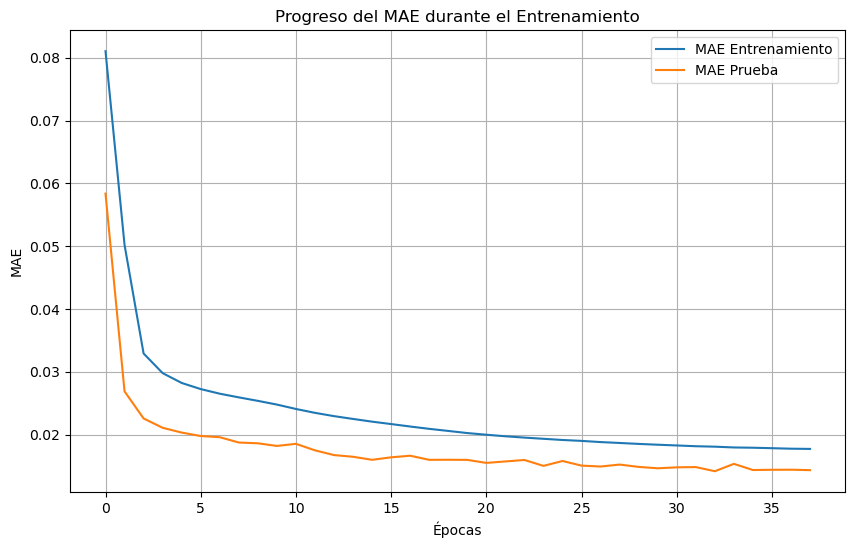

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step


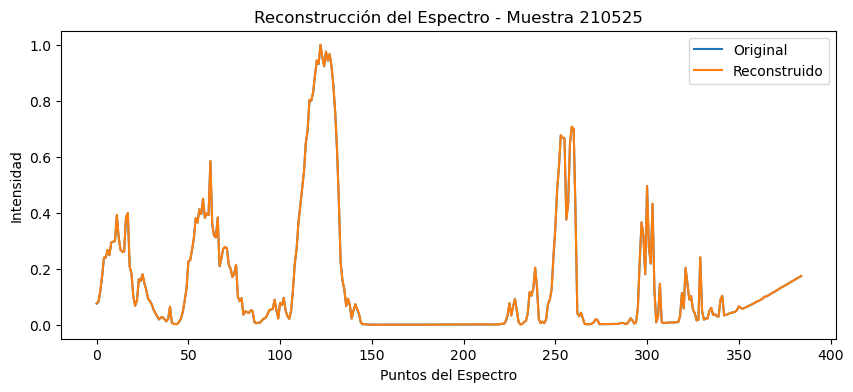

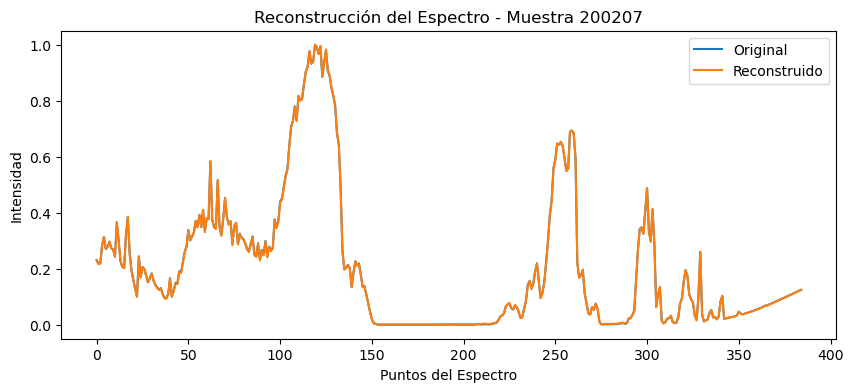

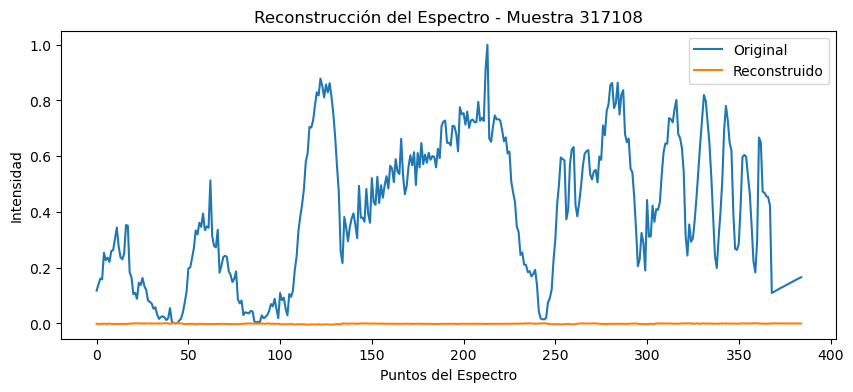

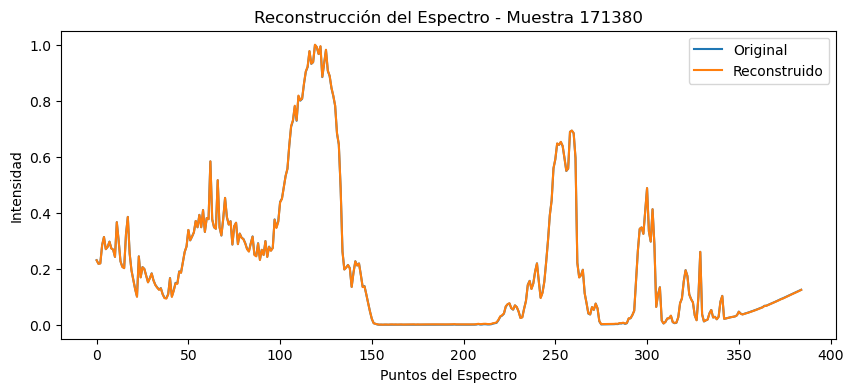

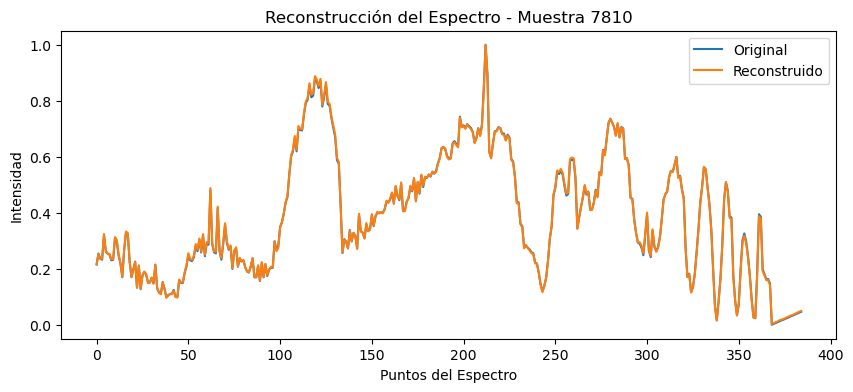

In [ ]:
# Train the autoencoder
history = autoencoder.fit(
    X_train_noisy,
    X_train_clean,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test_noisy, X_test_clean),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ],
)

# Save the trained model
autoencoder.save("AE_H2O.keras")

# Plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training MAE")
plt.plot(history.history["val_loss"], label="Validation MAE")
plt.title("MAE Progress During Training")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

# Predict reconstructed spectra on test data
decoded_spectra = autoencoder.predict(X_test_noisy)

# Visualize a few reconstructions
num_samples = 5  # Number of samples to visualize
indices = np.random.choice(len(X_test_noisy), num_samples, replace=False)

for idx in indices:
    plt.figure(figsize=(10, 4))
    plt.plot(X_test_clean[idx].flatten(), label="Original")
    plt.plot(decoded_spectra[idx].flatten(), label="Reconstructed")
    plt.xlabel("Spectrum Points")
    plt.ylabel("Intensity")
    plt.title(f"Spectrum Reconstruction - Sample {idx}")
    plt.legend()
    plt.show()


# Eval

In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras

# Load the trained autoencoder model and reconstruct the test spectra
autoencoder = keras.models.load_model("AE_H2O.keras")
X_reconstructed = autoencoder.predict(X_test_noisy)

# Compute evaluation metrics on the test set
mae = mean_absolute_error(X_test_clean, X_reconstructed)
print(f"Mean Absolute Error (MAE): {mae:.6f}")

mse = mean_squared_error(X_test_clean, X_reconstructed)
print(f"Mean Squared Error (MSE): {mse:.6f}")

r2 = r2_score(X_test_clean, X_reconstructed)
print(f"Coefficient of Determination (R²): {r2:.6f}")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step
Mean Absolute Error (MAE): 0.008202
Mean Squared Error (MSE): 0.001663
Coefficient of Determination (R²): 0.897435
